#**FER2013 XGBoost Implementation**

The GoogleColab used to pretrain XGBoost. **Disclaimer: XGBoost can only be deployed on Python. Use this if you're using Flask, Django, etc.**



###**Importing libraries**

In [ ]:
! pip install pillow-heif
! pip install opendatasets

import tensorflow as tf
import pandas as pd
import os
import opendatasets as od
from matplotlib import pyplot
from math import sqrt
import numpy as np
import scipy.misc
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, plot_importance, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.manifold import TSNE
from tensorflow.keras.preprocessing import image
from scipy.stats import uniform
from matplotlib.pylab import rcParams
from PIL import Image
import itertools
import glob
import random
from pillow_heif import register_heif_opener
from skimage import io
%matplotlib inline

###**Loading Dataset**

In [ ]:
dataset = 'https://www.kaggle.com/datasets/deadskull7/fer2013'

od.download(dataset)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: takanto
Your Kaggle Key: ··········


100%|██████████| 96.6M/96.6M [00:01<00:00, 86.7MB/s]


In [ ]:
df = pd.read_csv('fer2013/fer2013.csv')

df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


###**Data preprocessing**

In [ ]:
X = np.array(list(map(str.split, df.pixels)), np.float32)
X = X / 255.0

In [ ]:
X = X.reshape(X.shape[0], 48, 48, 1)

In [ ]:
y = np.array(df.emotion)
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
y = y.reshape(-1, 1)
y = enc.fit_transform(y)

###**Exploratory data analysis**

Then, the function below can plot 9 randomely selected images in np.array. The data can deal with plotting any dimenstion and color map.

In [ ]:
def plot_rand_imgs(data, img_size, pred='nan', actual='nan'):
  """
  choose 9 random images stored in numpy array and plot them

  Parameters
  -----------------
  data (numpy array): numpy array containing images
  img_size (tuple): image size of images

  Returns
  -----------------
  None (show plot)
  """
  # images selected
  random_ids = np.random.choice(data.shape[0], 9)

  # for every image, plot it as a subplot
  j = 0
  fig = plt.figure()
  for i in random_ids:
    ax = plt.subplot(330 + 1 + j)
    ax.axis('off')
    # if there is a list of predictions, display it as title
    if type(actual) != str:
      title = f'actual: {actual[i]}'
      if type(pred) != str:
        title += f', pred: {pred[i]}'
      ax.title.set_text(title)
    # if RGB is stored, convert it to RGB
    img = data[i]
    if img_size[2]==3:
      ax.imshow(cv2.cvtColor(img.reshape(img_size[0], img_size[1], 3), cv2.COLOR_BGR2RGB))
    # if grayscale is stored, plot it with gray color map
    elif img_size[2]==1:
      ax.imshow(img.reshape(img_size[0], img_size[1], 1), plt.get_cmap('gray'))

    j += 1

  plt.axis('off')
  plt.show()

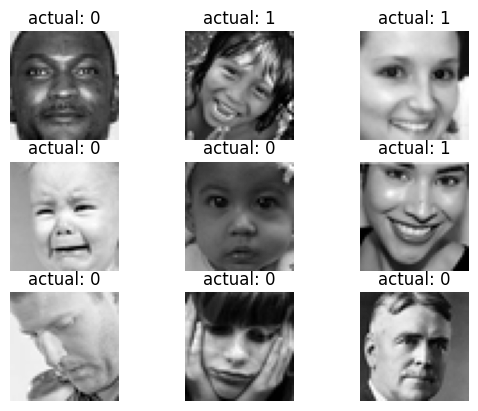

In [ ]:
plot_rand_imgs(X, img_size=(48,48,1), actual=y)

From the plots above, it can be confirmed that the data augumentations are performed correctly and the labels are correctly assigned. the function below generates dataframe of unique values and their frequency in a numpy array. It is used to see the frequency of drunk and sober face in both datasets.

###**Overall pipeline**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
print("dimensions of data used for training and testing")
print("training dataset: ", X_train.shape, y_train.shape)
print("test dataset: ", X_test.shape, y_test.shape)

dimensions of data used for training and testing
training dataset:  (28709, 48, 48, 1) (28709,)
test dataset:  (7178, 48, 48, 1) (7178,)


In [ ]:
X_train_3 = np.stack((X_train,)*3, axis=-1)
X_test_3 = np.stack((X_test,)*3, axis=-1)

X_train_3 = X_train_3.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 3)
X_test_3 = X_test_3.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 3)

print("training dataset: ", X_train_3.shape, y_train.shape)
print("test dataset: ", X_test_3.shape, y_test.shape)

training dataset:  (28709, 48, 48, 3) (28709,)
test dataset:  (7178, 48, 48, 3) (7178,)


####**Auto-encoder**

The following code cells build autoencoder and show the summary.

In [ ]:
def build_encoder(image_size):
  """
  return CNN encoder model

  Parameters
  -----------------
  image_size (array): image size array

  Returns
  -----------------
  model (tensorflow model): encoder model to encode image into 100 dimensions
  """
  i = Input(shape=image_size)
  x = Conv2D(64,(5,5), strides=2, padding = "same", activation=LeakyReLU(alpha=0.2))(i)
  x = Conv2D(128,(5,5), strides=2, padding = "same", activation=LeakyReLU(alpha=0.2))(x)
  x = Conv2D(256,(5,5), strides=4, padding = "same", activation=LeakyReLU(alpha=0.2))(x)
  x = Flatten()(x)
  x = Dense(100, activation="sigmoid")(x)

  model = Model(i,x)

  return model

In [ ]:
def build_decoder(latent_dim):
  """
  return CNN decoder model

  Parameters
  -----------------
  latent_dim (int): latent dimension to decode

  Returns
  -----------------
  model (tensorflow model): decoder model
  """
  i = Input(shape=(latent_dim,))
  x = Dense(2304, activation = LeakyReLU(alpha=0.2)) (i)
  x = Reshape((3,3,256)) (x)

  x = Conv2DTranspose(128, (5,5), strides = 4, padding = "same", activation = LeakyReLU(alpha=0.2))(x)
  x = Conv2DTranspose(64, (5,5), strides = 2, padding = "same", activation = LeakyReLU(alpha=0.2))(x)
  x = Conv2DTranspose(1, (5,5), strides = 2, padding = "same", activation = "sigmoid")(x)

  model = Model(i,x)
  return model

Encoder summary. It shrinks the image to 100 dimensions.

In [ ]:
encoder_check = build_encoder((48,48,1))
encoder_check.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 24, 24, 64)        1664      
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 128)       204928    
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 256)         819456    
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 100)               230500    
                                                                 
Total params: 1,256,548
Trainable params: 1,256,548
Non-train

Decoder summary. It expands 100 dimensional data back to (32,32,3). The layers are made to be symmetrical to the encoder.

In [ ]:
latent_dim = 100
decoder_check = build_decoder(latent_dim)
decoder_check.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_1 (Dense)             (None, 2304)              232704    
                                                                 
 reshape (Reshape)           (None, 3, 3, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 12, 12, 128)      819328    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 24, 24, 64)       204864    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 48, 48, 1)        1601

The below code cells construct, compile, and show the summary of the autoencoder.

In [ ]:
# initializing encoder and decoder
encoder = build_encoder([48,48,1])
decoder = build_decoder(latent_dim)

# defining and compiling autoencoder (loss is mean squared error)
img = Input(shape=[48,48,1])
z = encoder(img)
decoded = decoder(z)
auto_encoder = Model(img, decoded)

auto_encoder.compile(optimizer = Adam(0.0002, 0.5),
                    loss = "mse")

In [ ]:
auto_encoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 model_2 (Functional)        (None, 100)               1256548   
                                                                 
 model_3 (Functional)        (None, 48, 48, 1)         1258497   
                                                                 
Total params: 2,515,045
Trainable params: 2,515,045
Non-trainable params: 0
_________________________________________________________________


The below code trains the model and display the loss.

In [ ]:
# fitting the model to training images
r = auto_encoder.fit(X_train, X_train, epochs=50, verbose=1)

Epoch 1/50
667/898 [=====================>........] - ETA: 11s - loss: 0.0298

KeyboardInterrupt: 

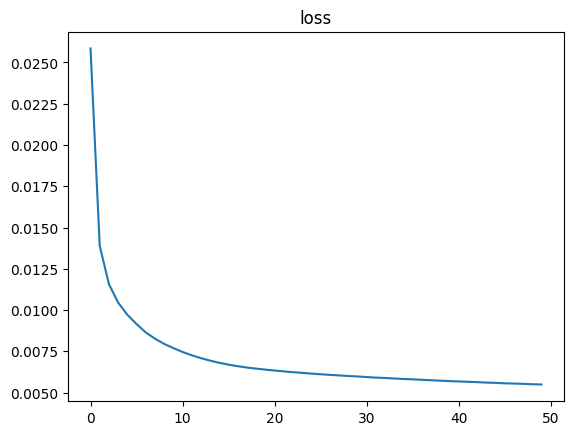

In [ ]:
# plotting loss
plt.plot(r.history["loss"])
plt.title("loss")
plt.show()

After 200 epochs, loss is below 0.005. The result of autoencoder can be visualized by encoding and decoding the image. The below code cells encode and decode the image for the visualizations.

In [ ]:
# performing encoding and decoding
train_pred = auto_encoder.predict(X_train)
test_pred = auto_encoder.predict(X_test)

225/225 [==============================] - 2s 9ms/step


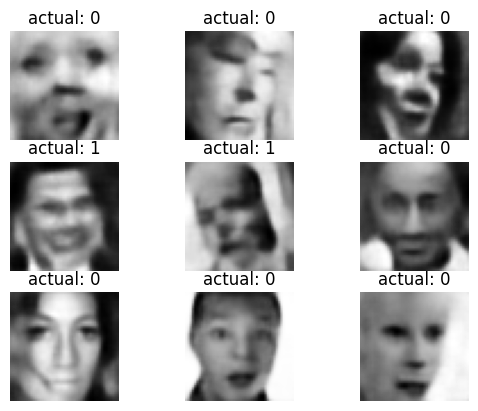

In [ ]:
plot_rand_imgs(train_pred, img_size=(48,48,1), actual=y_train)

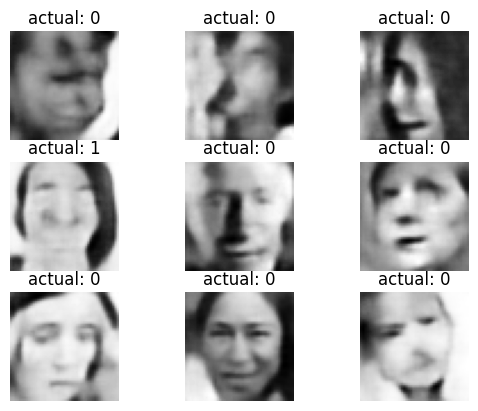

In [ ]:
plot_rand_imgs(test_pred, img_size, actual=y_test)

The decoded images are very similar to the original image, implying that the images are encoded well in the latent dimension. The images are now encoded for dimensionality reduction below.

In [ ]:
# using encoder for dimensionality reduction
X_train_ae = encoder.predict(X_train)
X_test_ae = encoder.predict(X_test)

225/225 [==============================] - 1s 2ms/step


In [ ]:
print("dimensions of data after dimensionality reduction")
print("trining dataset: ", X_train_ae.shape, y_train.shape)
print("test dataset: ", X_test_ae.shape, y_test.shape)

dimensions of data after dimensionality reduction
trining dataset:  (28709, 100) (28709,)
test dataset:  (7178, 100) (7178,)


From the above, we can see that the data's demension is reduced to 100 dimensions.  

**Visualizing Results from Dimensionality Reduction**

In [ ]:
# fitting T-SNE and trasnforming encoded training data
X_embedded_ae = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X_train_ae[:5000])

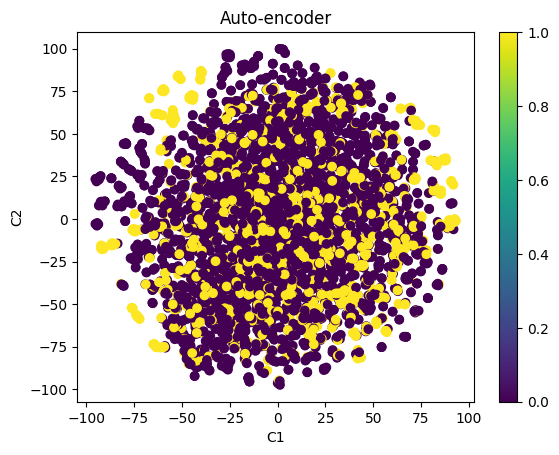

In [ ]:
# plotting transformed training data
plt.title("T-SNE Visualizations for Auto-encoder and LDA outputs")
plt.scatter(X_embedded_ae[:, 0], X_embedded_ae[:, 1], c = y_train[:5000])
plt.title("Auto-encoder")
plt.colorbar()
plt.xlabel('C1')
plt.ylabel('C2')
plt.show()

From the above, it is already possible to see some clustering that can be used for the XGBoost.

####**Transfer Learning**

In [ ]:
def build_vgg_model(image_size):
  """
  return frozen VGG model

  Parameters
  -----------------
  image_size (array): image size array

  Returns
  -----------------
  model (tensorflow model): frozen VGG model
  """
  ptm = PretrainedModel(include_top = False, weights = 'imagenet', input_shape = image_size)
  ptm.trainable = False

  x = Flatten()(ptm.output)
  model = Model(inputs=ptm.input, outputs = x)

  return model

In [ ]:
# initializing the model
vgg_model = build_vgg_model((48,48,3))

vgg_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                            

The below uses frozen VGG16 model to extract features.

In [ ]:
# using VGG16 for feature extraction
train_features = vgg_model.predict(X_train_3)
test_features = vgg_model.predict(X_test_3)

225/225 [==============================] - 3s 13ms/step


The extracted features are concatenated to the outputs from auto-encoder and LDA to see if features can improve the classification performance.

In [ ]:
# concatenating the features extracted to the transformed images
X_train_ae_tl = np.concatenate((X_train_ae, train_features),axis=1)
X_test_ae_tl = np.concatenate((X_test_ae, test_features),axis=1)

In [ ]:
print("dimensions of data after concatenation")
print("trining dataset (Auto-encoder): ", X_train_ae_tl.shape, y_train.shape)
print("test dataset (Auto-encoder): ", X_test_ae_tl.shape, y_test.shape)

dimensions of data after concatenation
trining dataset (Auto-encoder):  (28709, 612) (28709,)
test dataset (Auto-encoder):  (7178, 612) (7178,)


From the model summary, it is noticeable that VGG16 outputs a vector containing 512 features. The above code matches the expected size of the input vectors after concatenation.

###**XGBoost Cross Validation for Hyperparameter Tuning**

In [ ]:
def randomsearchCV_XGB_categorical(X_train, y_train, parameters, scoring_type='f1_weighted'):
  """
  Perform random search cross validation for XGBoost binary classier

  Parameters
  -----------------
  X_train (np array): the features used in predicting y in training data
  y_train (np array): the labels to be classifed in the training data
  parameters (dict): parameters and distributions to take parameters from
  scoring_type (str, default=f_1weighted): score to be looked at when choosing the best parameters

  Returns
  -----------------
  best params (dict): best parameters identified stored in a dict
  best score (float): best score from the model with the best parameters
  """
  estimator= XGBClassifier(objective='multi:softmax',
                          num_class=7,
                          n_estimators=100,
                          tree_method='hist',
                          seed=42)

  cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=1)

  scoring= {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score, average = 'macro'),
           'recall': make_scorer(recall_score, average = 'macro'),
           'f1_macro': make_scorer(f1_score, average = 'macro'),
           'f1_weighted': make_scorer(f1_score, average = 'weighted')}

  rand_search = RandomizedSearchCV(
      estimator=estimator,
      param_distributions=parameters,
      scoring = scoring[scoring_type],
      n_iter=20,
      n_jobs=10,
      cv = cv,
      verbose=0
  )

  rand_search.fit(X_train, y_train)

  return rand_search.best_params_, rand_search.best_score_

In [ ]:
parameters = {
      'learning_rate': uniform(loc=0.001, scale=1),
      'gamma': uniform(loc=0, scale=2),
      'min_child_weight': uniform(loc=0, scale=2)
}

params, score = randomsearchCV_XGB_categorical(X_train_ae_tl, y_train, parameters, scoring_type='f1_weighted')

print("best parameters: ", params)
print("best score: ", score)

best parameters:  {'gamma': 0.8606347768185687, 'learning_rate': 0.21143825315006315, 'min_child_weight': 0.029940239522247225}
best score:  0.793579227120729


###**XGBoost Training**

In [ ]:
xgb_clf = XGBClassifier(objective='multi:softmax',
                          num_class=7,
                          n_estimators=100,
                          gamma=params['gamma'],
                          learning_rate=params['learning_rate'],
                          min_child_weight=params['min_child_weight'],
                          tree_method='hist',
                          seed=42)
xgb_clf.fit(X_train_ae_tl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.8606347768185687, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.21143825315006315,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=0.029940239522247225, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

###**Model Evaluation**

This section performs predictions to visualize result in the next section. It is important to keep in mind that the principle components are different between datasets, and corresponding trasnformed test datasets need to be used for performing predictions.

In [ ]:
models, predictions = clf.fit(X_train_ae_tl, X_test_ae_tl, y_train, y_test)

 38%|███▊      | 11/29 [09:02<05:01, 16.75s/it]

In [ ]:
pred_xgb = xgb_clf.predict(X_test_ae_tl)

In [ ]:
print(classification_report(y_test, pred_xgb))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      5364
           1       0.75      0.42      0.53      1814

    accuracy                           0.82      7178
   macro avg       0.79      0.68      0.71      7178
weighted avg       0.81      0.82      0.80      7178



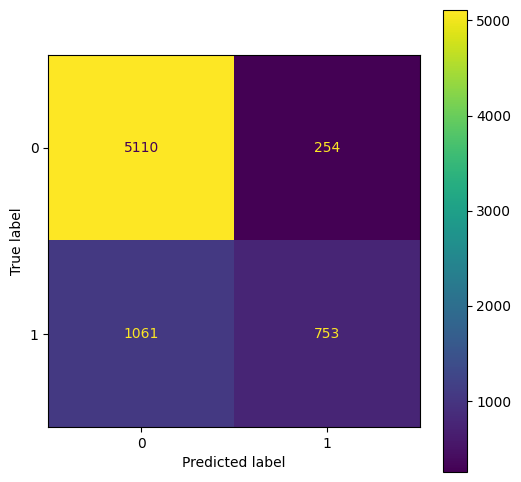

In [ ]:
cm = confusion_matrix(y_test, pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

rcParams['figure.figsize'] = 6,6
disp.plot()
plt.show()

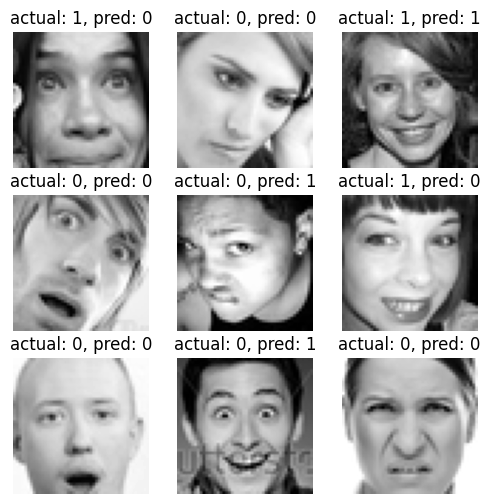

In [ ]:
# change pred to see the predictions from different models
plot_rand_imgs(X_test, img_size=(48,48,1), pred=pred_xgb, actual=y_test)

###**Saving the model**

In [ ]:
encoder.save('fer13_encoder.h5')
encoder_weights = encoder.get_weights()

model_dir = "model_dir"
if not os.path.exists(model_dir):
  os.makedirs(model_dir)
np.save(os.path.join(model_dir, 'fer13_encoder_weights'), encoder_weights)

In [ ]:
vgg_model.save('fer13_vgg.h5')
vgg_weights = vgg_model.get_weights()

model_dir = "model_dir"
if not os.path.exists(model_dir):
  os.makedirs(model_dir)
np.save(os.path.join(model_dir, 'fer13_vgg_weights'), vgg_weights)

In [ ]:
bst.save_model('fer13_xgb.json')